## Modelarea SVM

Algoritmul SVM oferă o gamă de funcții ale nucleului pentru efectuarea procesării acestuia. Practic, maparea datelor într-un spațiu dimensional mai înalt se numește kernelling. Funcția matematică folosită pentru transformare este cunoscută sub numele de funcție kernel și poate fi de diferite tipuri, cum ar fi:

- 1.Liniar
- 2.Polinom
- 3.Funcția de bază radială (RBF)
- 4.Sigmoid
Fiecare dintre aceste funcții are caracteristicile sale, avantajele și dezavantajele sale și ecuația sa, dar nu există o modalitate ușoară de a ști care funcție funcționează cel mai bine cu un anumit set de date.

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

import os

import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

Citirea bazei de date initiala si afisare detalii variabile

In [3]:
df=pd.read_csv('2019.csv')
print(df)
print(len(df))
print(df.shape)
df.dtypes

     Overall rank         Country or region  Score  GDP per capita  \
0               1                   Finland  7.769           1.340   
1               2                   Denmark  7.600           1.383   
2               3                    Norway  7.554           1.488   
3               4                   Iceland  7.494           1.380   
4               5               Netherlands  7.488           1.396   
..            ...                       ...    ...             ...   
151           152                    Rwanda  3.334           0.359   
152           153                  Tanzania  3.231           0.476   
153           154               Afghanistan  3.203           0.350   
154           155  Central African Republic  3.083           0.026   
155           156               South Sudan  2.853           0.306   

     Social support  Healthy life expectancy  Freedom to make life choices  \
0             1.587                    0.986                         0.596   
1  

Overall rank                      int64
Country or region                object
Score                           float64
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

Realizarea de grafice pentru a observa legaturile dintre variabile la nivel global

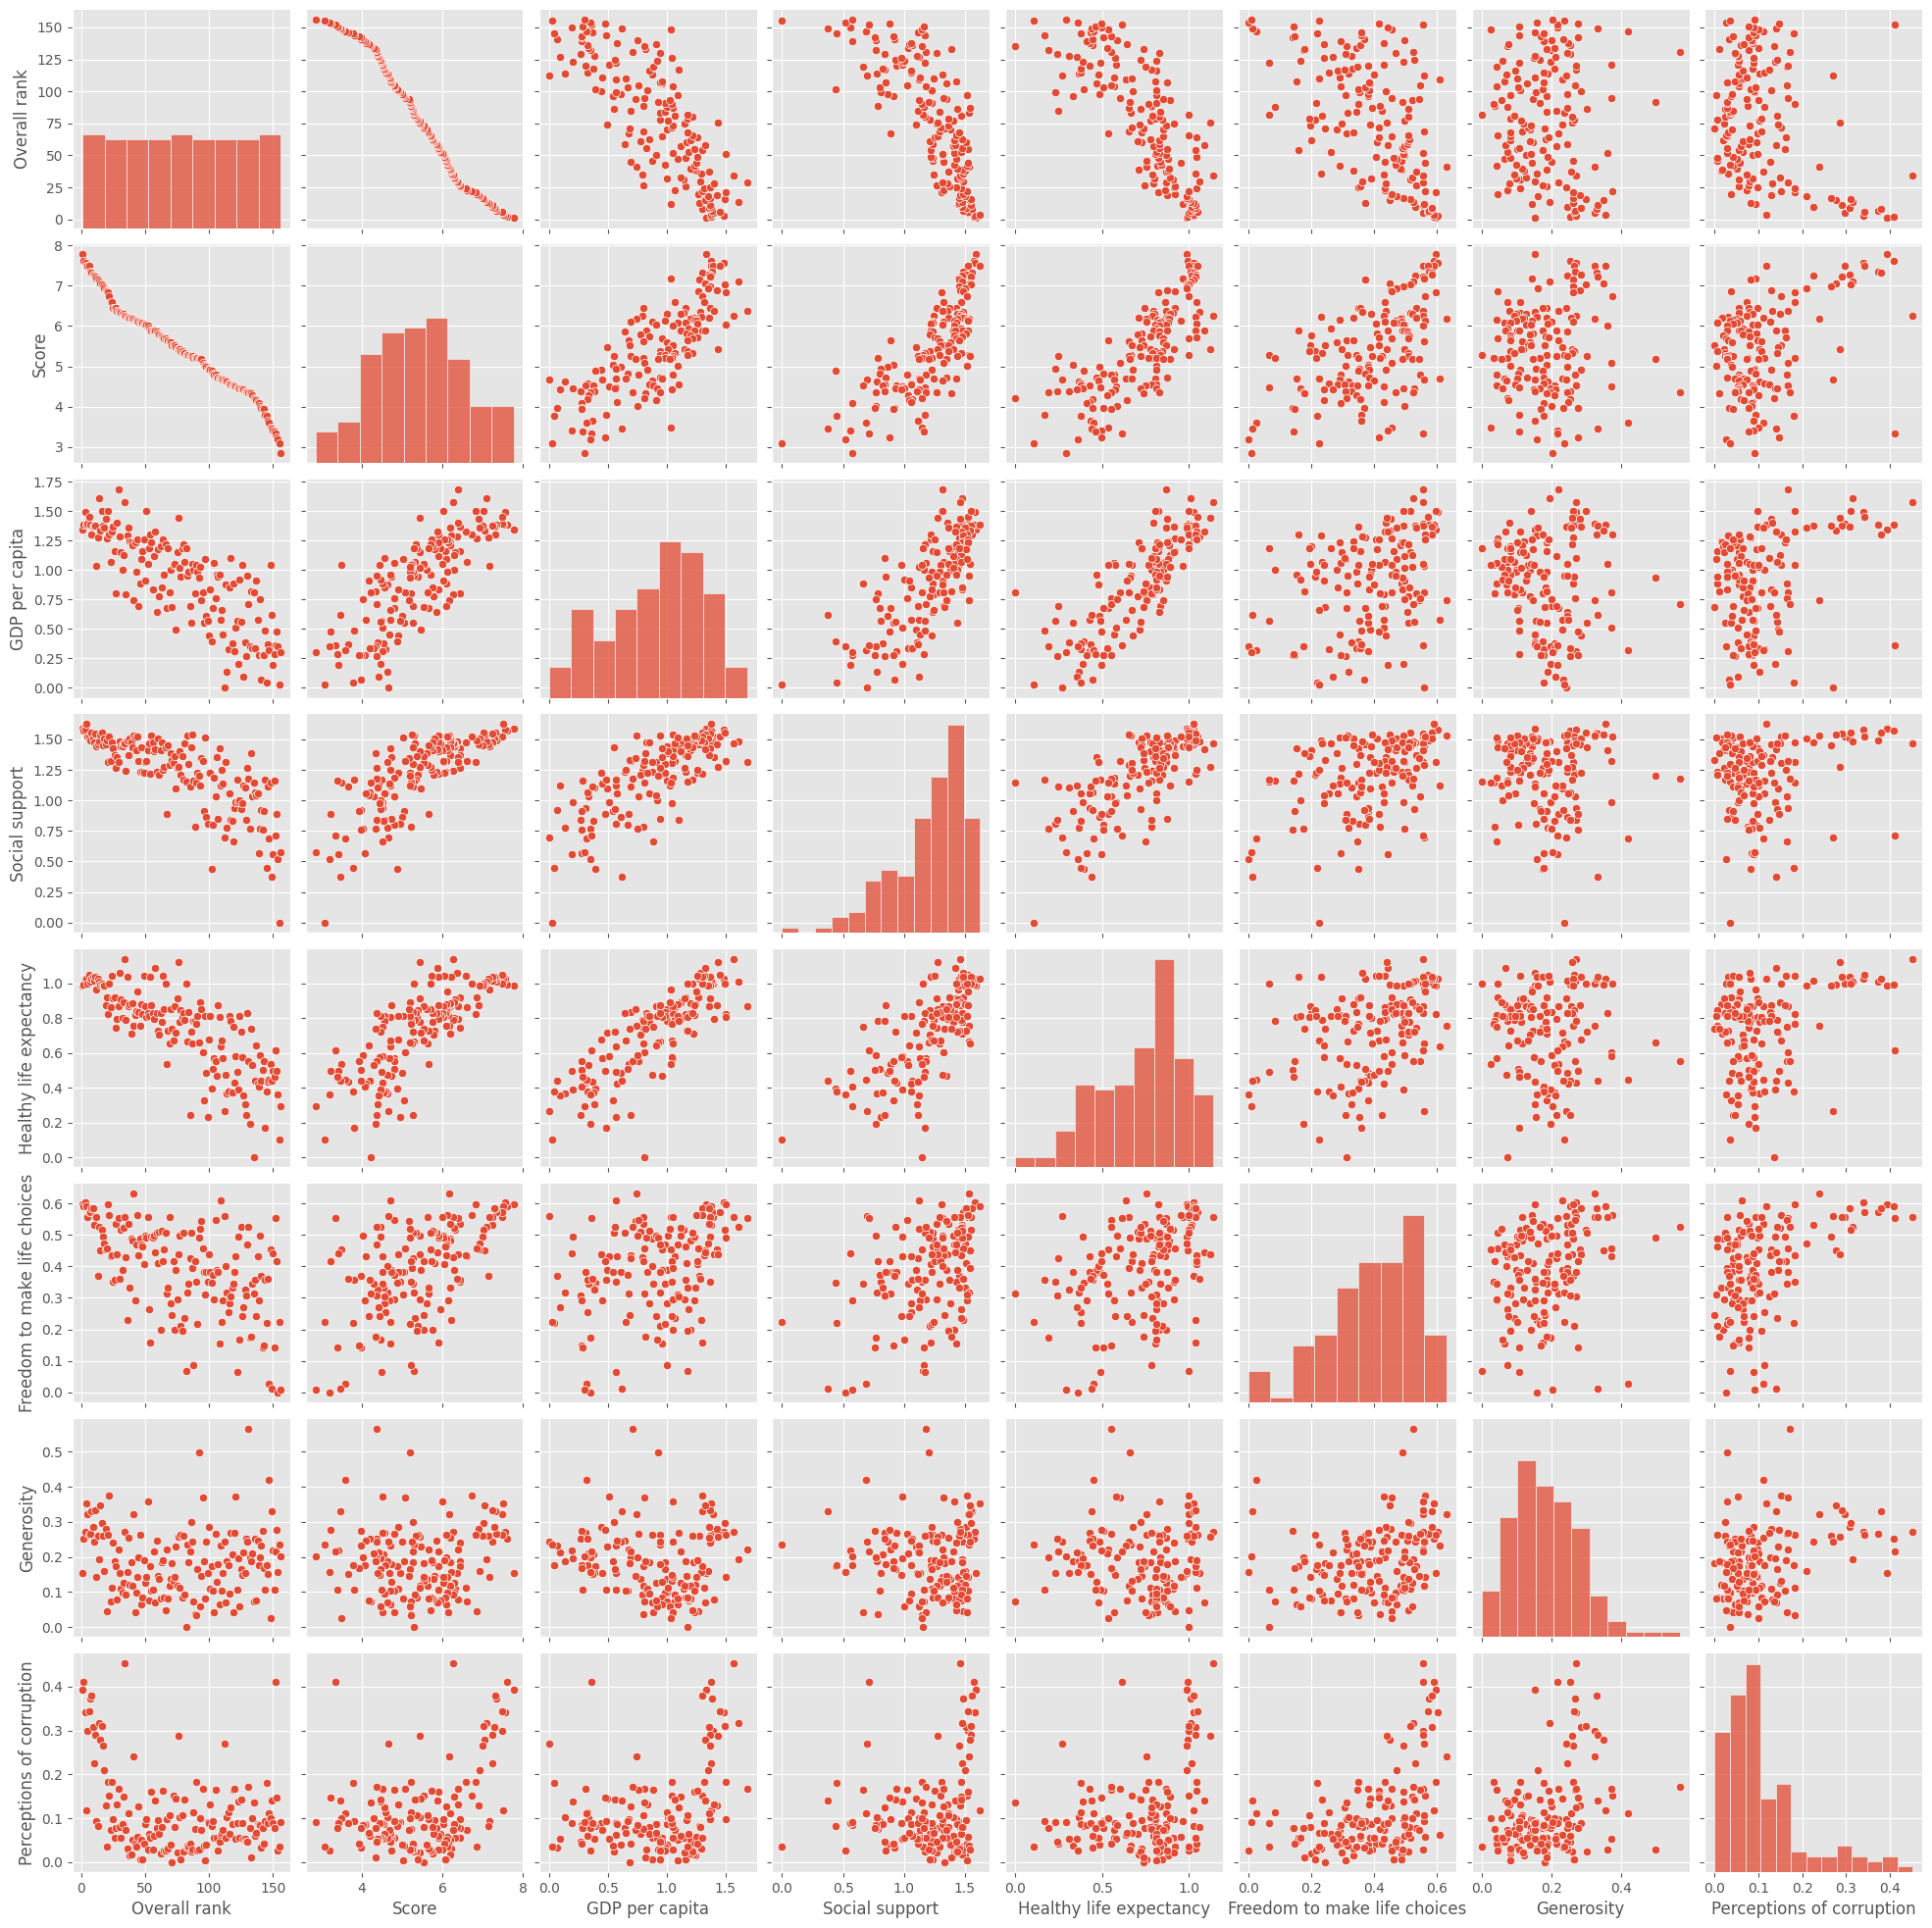

In [4]:
import seaborn as sns
sns.pairplot(df)

Afisare la nivel grafic Top 10 Tari pentru diferitele atribute ale bazei de date

<Axes: xlabel='Perceptions of corruption', ylabel='Country or region'>

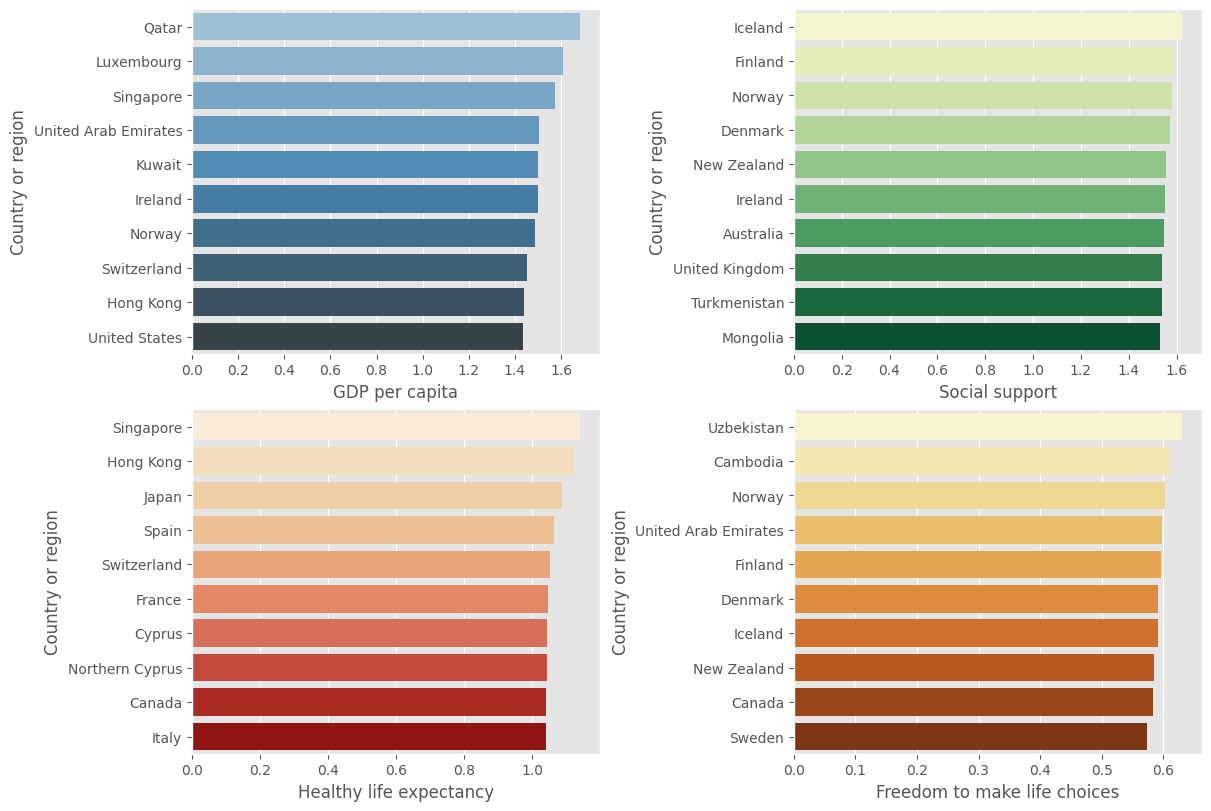

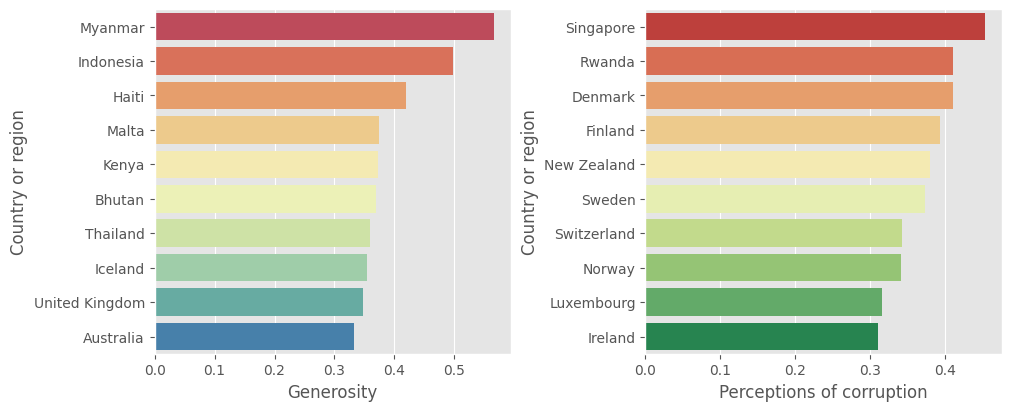

In [5]:

fig, axes = plt.subplots(nrows=2, ncols=2,constrained_layout=True,figsize=(12,8))

sns.barplot(x='GDP per capita',y='Country or region',data=df.nlargest(10,'GDP per capita'),ax=axes[0,0],palette="Blues_d")
sns.barplot(x='Social support' ,y='Country or region',data=df.nlargest(10,'Social support'),ax=axes[0,1],palette="YlGn")
sns.barplot(x='Healthy life expectancy' ,y='Country or region',data=df.nlargest(10,'Healthy life expectancy'),ax=axes[1,0],palette='OrRd')
sns.barplot(x='Freedom to make life choices' ,y='Country or region',data=df.nlargest(10,'Freedom to make life choices'),ax=axes[1,1],palette='YlOrBr')

fig, axes = plt.subplots(nrows=1, ncols=2,constrained_layout=True,figsize=(10,4))
sns.barplot(x='Generosity' ,y='Country or region',data=df.nlargest(10,'Generosity'),ax=axes[0],palette='Spectral')
sns.barplot(x='Perceptions of corruption' ,y='Country or region',data=df.nlargest(10,'Perceptions of corruption'),ax=axes[1],palette='RdYlGn')

Se pot observa urmatoarele:


*   Tarile cu un nivel ridical al PIB per capita sunt fie state din Golful Persic, fie mari economii mondiale
*   In ceea ce priveste partea de suport social(din partea Statului), pe primele locuri se afla tari nordice
*  In ceea ce priveste speranta medie de viata, pe primele locuri se afla marile economii din Asia




Urmatoarea etapa in analiza aceasta este realizarea unui HeatMap pentru a observa corelatia si intensitatea legaturii dintre variabilele propuse in model.

Vom analiza toate variabilele mai putin cea de tip calitativ *Country or region*.

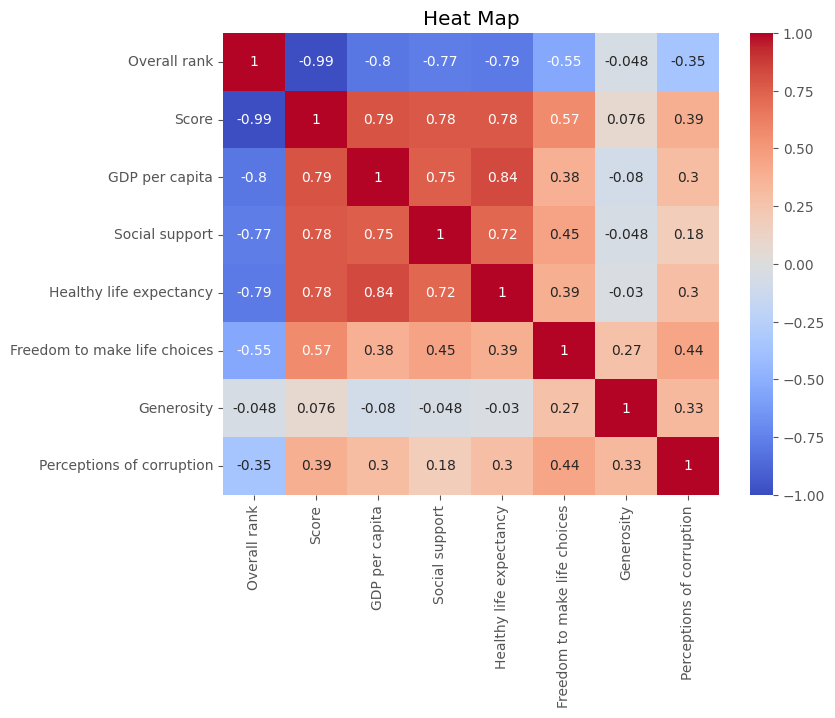

In [6]:
import pandas as pd

# Definirea datelor tale (exemplu)
X = df[['Overall rank','Score','GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices','Generosity','Perceptions of corruption']]

# Calcularea matricei de corelație
matrice_corelatie_explicative = X.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(matrice_corelatie_explicative, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heat Map')
plt.show()


Conform rezultatelor obtinute pe baza HeatMap-ului se poate observa cum culorile ft bine evidentiate arata o legatura puternica intre variabile.
Concret,conform si analizelor din regresie,vom considera:

*   var independete(explicative):GDP per capita, Social support, Healthy life expectancy
*   var dependenta(target):score

Se va crea o noua coloana * Category*, unde se vor asigna valori numerice de la 1 la 3 pentru toate tarile implicate in analiza, in functie de asa-numitul *Score of Happiness*.

Mai intai,se vor calcula limitele intervalului dupa care se va face atribuirea, cu urmatoarea legenda:


*  1=nivel ridicat de calitate/fericire a vietii
*  2=nivel mediu
*  3=nivel scazut





In [7]:

print('max:',df['Score'].max())
print('min:',df['Score'].min())
add=df['Score'].max()-df['Score'].min()
grp=round(add/3,3)
print('range difference:',(grp))
low=df['Score'].min()+grp
mid=low+grp
print('upper bound of Low grp',low)
print('upper bound of Mid grp',mid)
print('upper bound of High grp','max:',df['Score'].max())


max: 7.769
min: 2.853
range difference: 1.639
upper bound of Low grp 4.492
upper bound of Mid grp 6.131
upper bound of High grp max: 7.769


In [8]:
cat=[]
for i in df.Score:
    if(i>0 and i<low):
        cat.append(3)

    elif(i>low and i<mid):
         cat.append(2)
    else:
         cat.append(1)

df['Category']=cat

Urmatorul pas in analiza de tip SVM, o reprezinta atribuirea pentru variabilele X si Y ce alcatuiesc modelul, etapa specifica de Preprocesarea a datelor.

Pentru a avea o distributie aleatoare a valorilor din setul de date, voi elimina coloana *Overall rank* care tinea evidenta ierarhica.

In [9]:
df = df.drop('Overall rank', axis=1)

Mai mult, chiar daca am eliminat acea coloana de ierarhizare, datele tot in aceeasi ordine au ramas.
Pentru a restabili totusi o ordine aleatoare a variabilelor, am ales o permutare intre liniile bazei de date, prin comanda specifica *random.permutation*.

In [10]:
#shuffle valori in setul de date
#pentru a putea realiza o predictie de tip SVM
df1 = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
print(df1)

    Country or region  Score  GDP per capita  Social support  \
0              Panama  6.321           1.149           1.442   
1             Romania  6.070           1.162           1.232   
2         Ivory Coast  4.944           0.569           0.808   
3              Israel  7.139           1.276           1.455   
4               China  5.191           1.029           1.125   
..                ...    ...             ...             ...   
151              Chad  4.350           0.350           0.766   
152         Mauritius  5.888           1.120           1.402   
153             India  4.015           0.755           0.765   
154        Luxembourg  7.090           1.609           1.479   
155             Spain  6.354           1.286           1.484   

     Healthy life expectancy  Freedom to make life choices  Generosity  \
0                      0.910                         0.516       0.109   
1                      0.825                         0.462       0.083   
2        

In [11]:
feature_df = df1[['GDP per capita', 'Social support', 'Healthy life expectancy']]
x = np.asarray(feature_df)
x[0:5]

array([[1.149, 1.442, 0.91 ],
       [1.162, 1.232, 0.825],
       [0.569, 0.808, 0.232],
       [1.276, 1.455, 1.029],
       [1.029, 1.125, 0.893]])

In [12]:
y = np.asarray(df1['Category'])
y[0:5]

array([1, 2, 2, 1, 2], dtype=int64)

Urmatoarea etapa consta in split in set de testare si antrenare.
Vom considera 80% dintre valori drept set de antrenare si restul de 20% drept testare.
Astfel, pe baza celor 124 de valori din setul de antrenare, 32 de valori vor fi previzionate.

In [14]:
x_train_size = int(len(x) * 0.80)
x_trainset, x_testset= x[0:x_train_size], x[x_train_size:]

In [15]:
y_train_size = int(len(y) * 0.80)
y_trainset, y_testset= y[0:y_train_size], y[y_train_size:]

In [16]:
print ('Train set:', x_trainset.shape,  y_trainset.shape)
print ('Test set:', x_testset.shape,  y_testset.shape)

Train set: (124, 3) (124,)
Test set: (32, 3) (32,)


Etapa practica de antrenarea a modelului, prin functia de baza radiala.

In [17]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(x_trainset, y_trainset)

SVC()

Predictie pe baza setului de antrenare pt setul de testare din x.

In [18]:
y_pred = clf.predict(x_testset)
y_pred [0:5]

array([1, 1, 1, 2, 3], dtype=int64)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

Definirea functiei pentru Confusion Matrix.

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Afisarea confusion matrix


              precision    recall  f1-score   support

           1       0.90      0.82      0.86        11
           2       0.60      0.75      0.67        12
           3       0.71      0.56      0.63         9

    accuracy                           0.72        32
   macro avg       0.74      0.71      0.72        32
weighted avg       0.74      0.72      0.72        32

Confusion matrix, without normalization
[[9 2 0]
 [1 9 2]
 [0 4 5]]


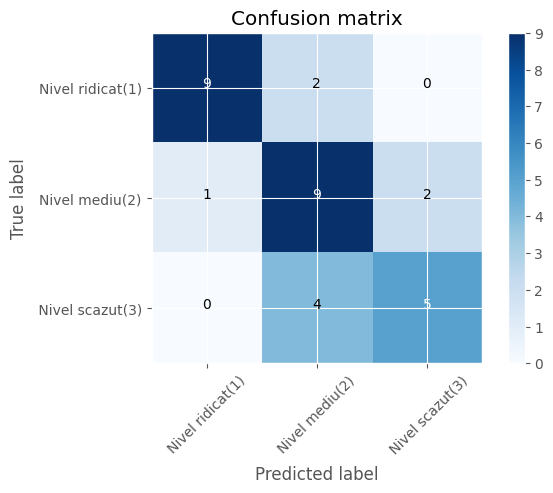

In [21]:
# Calcul Confusion matrix
cnf_matrix = confusion_matrix(y_testset, y_pred, labels=[1,2,3])
np.set_printoptions(precision=2)

print (classification_report(y_testset, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Nivel ridicat(1)','Nivel mediu(2)',' Nivel scazut(3)'],normalize= False,  title='Confusion matrix')

Calculul scorului f1

In [22]:

from sklearn.metrics import f1_score
f1_score(y_testset, y_pred, average='weighted')

0.7204241071428571

Un scor f1 in valoare de 0,72 arata o performanta medie spre buna a modelului.
Valoarea relativ mica se poate datora numarului mic de observatii.

Calculul indicelui Jaccard pentru acuratete

In [23]:
from sklearn.metrics import jaccard_score
jaccard_score(y_testset, y_pred,average='micro')

0.5609756097560976

O valoare de 0,56 a indicelui Jaccard reprezinta un nivel mediu de acuratete, cumva aproximativ jumatate dintre valorile din setul de date previzionat iau aceleasi valori ca inregistrarile din setul de initial.
Cumva acest lucru poate explica culoarea pregnanta si nr mare de valori obtinute pentru varianta 2, aceea ca o tara/regiune sa inregistreze un nivel mediu de calitate/fericire.